In [1]:
library(ggplot2)

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

# Section B. Prediction Uncertainty with Bootstrapping

## Question 3 [Bootstrapping]


In [2]:
train = read.csv("assignment1_datasets/Task1B_train.csv")
test = read.csv("assignment1_datasets/Task1B_test.csv")

In [3]:
train_features = as.matrix(train[,-5])
train_target = as.matrix(train[,5])
test_features = as.matrix(test[,-5])
test_target = as.matrix(test[,5])

### I

Here we define a few auxiliary functions that can help us calculate the MSE and Predictions ( KNN regressor ) for the task to follow

In [4]:
calculate_error <- function(y,ypredict){
    mse = mean((y-ypredict)**2)
    return(mse)
}

In [5]:
knn <- function(train_features, train_target, test_features, k=4){
    train_len = nrow(train_features)
    test_len = nrow(test_features)
    prediction = c(1:nrow(test_features))*0

    
    distance = as.matrix(dist(rbind(test_features, train_features), method= "euclidean"))
    distance = distance[1:test_len,(test_len+1):(train_len+test_len)]
    
    for (i in 1:test_len){
        closest_index = as.data.frame(sort(distance[i,],index.return = TRUE))[1:k,2]
        prediction[i] = mean(train_target[closest_index])
    }
    
    return(as.matrix(prediction))
    
}

The boot function returns samples created from the data with fixed sample size. Each sample consists of indices of datapoints to be used for that particular sample.

In [6]:
boot <- function (data, sample_size, no_samples=100){
    indx <- matrix(nrow=no_samples, ncol=sample_size)
    for (s in 1:no_samples){
        indx[s, ] <- sample(x=data, size=sample_size, replace = TRUE)
    }
    return(indx)
}

We now use the KNN regression with bootstapping. 
- K = Neighbourhood Size
- L = Number of Samples
- N = Sample Size

Running this function can take time as it performes KNN regression for L*K times

In [7]:
bootstrap_reg <- function(train_features, train_target, test_features, test_target, K=30, L=40, N=50){
    boot_indx <- boot(nrow(train_features), N, L)
    errors <- data.frame('K'=1:K, 'L'=1:L, 'error'=rep(0,L*K))

    for (kn in 1:K){
        
        for (l in 1:L){
            i <- (kn-1)*L+l
            indx <- boot_indx[l,]
            errors[i,'K'] <- kn
            errors[i,'L'] <- l
            prediction= knn(train_features[indx,], train_target[indx], test_features, k = kn)
            
            errors[i,'error'] <-  calculate_error(test_target,prediction)
     
            
        }
        
    }
    
    return(errors)

}


### II
The following code is expected to take a few minutes to run. 

In [8]:
errors = bootstrap_reg(train_features, train_target, test_features, test_target, K=20, L=100, N=25)
errors["Type"] = "Test"

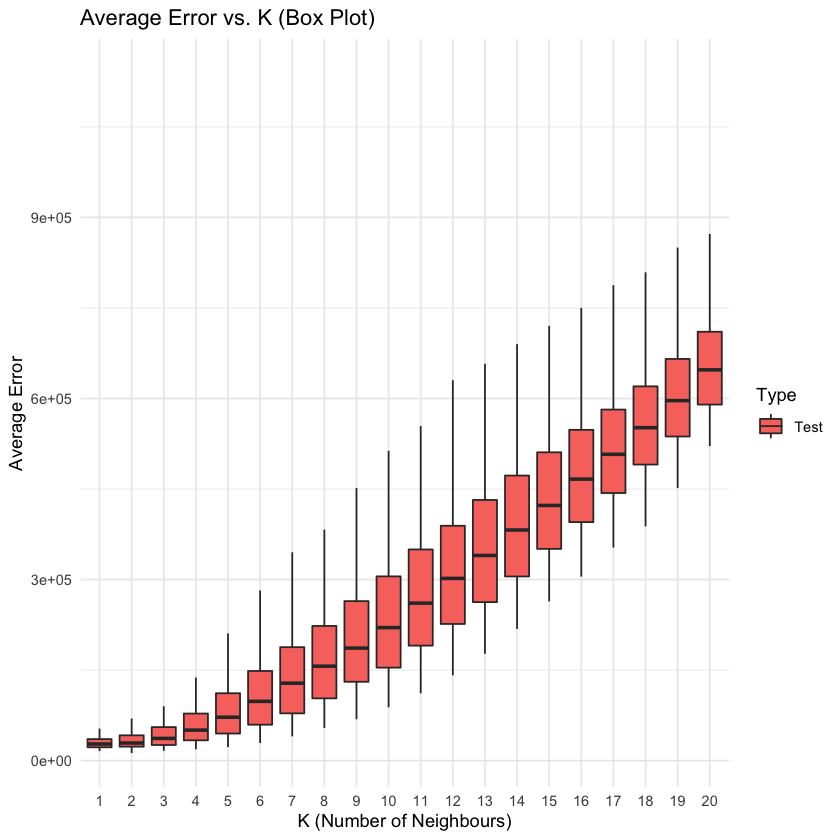

In [9]:
ggplot(data=errors, aes(factor(K), error,fill=Type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Average Error vs. K (Box Plot)')+xlab("K (Number of Neighbours)") +ylab("Average Error")+ theme_minimal()

### III

From the graph above we can see that as the number of K increases the uncertainty increases and so does the average error. This could be due to the following reasons
- The sample size chosen is very small as compared to the original data size. Generally we would want to keep the sample size close to the number of data points available 
- In case the sample size is small and the value of K is comparable with the sample size, and as K would come close to the sample size, the prediction(not the error) would vary by a very little amount. Therefore, as the prediction would become constant if the sample size is equal to the value of K, the error would increase for each sample. This nature can be observed from the graph above, i.e. the error is increasing as the value of K increases
- With the similar analogy, with different samples, the predicted value would change drastically as the size of K increases and hence the uncertainty increases.


### IV 
In the following task we compare the error and uncertainty as the number of bootstrap increases

In [10]:
bootstrap_reg_mod <- function(train_features, train_target, test_features, test_target, K=10, L=40, N=50){
    
    errors <- data.frame('LS'= rep(0,(10*(L%%10)+L)) , 'L'=rep(0,(10*(L%%10)+L)) , 'error'=rep(0,(10*(L%%10)+L)))

    i = 0
    for (ls in seq(10,L,10)){
        
        boot_indx <- boot(nrow(train_features),N, ls)
        
        for (l in 1:ls){
            i <- i + 1
            indx <- boot_indx[l,]
            errors[i,'LS'] <- ls
            errors[i,'L'] <- l
            prediction= knn(train_features[indx,], train_target[indx], test_features, k = K)
            errors[i,'error'] <-  calculate_error(test_target,prediction)
     
            
        }
        
    }
    
    return(errors)

}

The cell below is used to evaluate the error for different values of K.

In [11]:
errors_mod = bootstrap_reg_mod(train_features, train_target, test_features, test_target, K=10, L=200, N=25)


The cell below is used to plot the average error v/s number of samples as a boxplot. To save the plot to the directory uncomment the two functions.

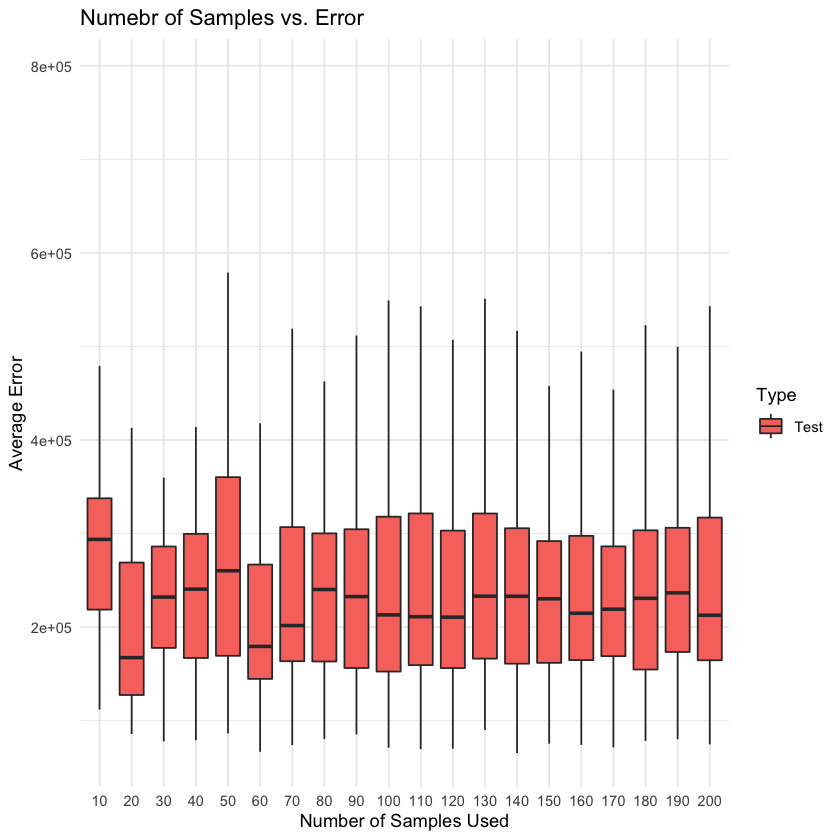

In [12]:
errors_mod["Type"] = "Test"

# jpeg('train_test_error.jpg',width = 1200, height = 350)
ggplot(data=errors_mod, aes(factor(LS), error,fill=Type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Numebr of Samples vs. Error') + theme_minimal() + labs(x= "Number of Samples Used",y = "Average Error")
# dev.off()

### V

From the graph above we can see that even the the number of samples are increasing still the uncertainty in average error and the average error itself does not change by much. This could be because as the sample size is small, each sample does not capture the true trend of original population. Hence no matter how many number of samples are drawn, te variance in error is quite high.